# **Demo Overview: UNet-Based Bamboo Segmentation**

This demo demonstrates how to train UNet-based semantic segmentation models for bamboo mapping using remote sensing imagery.
The supported input data sources include:

- RGB imagery

- Canopy Height Model (CHM)

- Fusion of RGB and CHM data

The demo focuses on image-based segmentation workflows and does not directly process raw point cloud data.


#### Contact Information

Prof. Chinsu Lin: chinsu@mail.ncyu.edu.tw

Prof. Wenzhi Liao: wenzhi.liao@ugent.be

# Model training with your annotated images

### STEP1: configure the path of image, masks and save_checkpoints

In [1]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

#import wandb
from utils.evaluate import evaluate
from unet import UNet
from utils.data_loading import BasicDataset
from utils.dice_score import dice_loss


def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    # 1. Create dataset
    dataset = BasicDataset(dir_img, dir_mask, img_scale)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                print(f"loss: {loss.item()}")
                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

        # Save checkpoint every 10 epochs
        if (save_checkpoint)&(epoch % save_interval == 0):
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')





## configure the data root for model training
Change here to adapt to your data


In [2]:
mode = 'RGB'
# mode = 'CHM'
# mode = 'Fusion'


In [4]:
import os
from skimage.io import imread,imsave, imshow
from pathlib import Path
import numpy as np
from tqdm import tqdm  # often cleaner

# =========================
# CONFIG data root
# =========================
dir_RGB = Path('./data/annotations/train/RGB/')
dir_CHM = Path('./data/annotations/train/CHM/')
dir_mask = Path('./data/annotations/train/masks/')

if mode == "RGB":
    dir_img = dir_RGB
    n_channels=3 
elif mode == "CHM":
    dir_img = dir_CHM
    n_channels=1

else:
    dir_img = Path('./data/annotations/train/fusion/')
    n_channels=4
    os.makedirs(dir_img, exist_ok=True)
    # ---------------- MAIN ----------------
    rgb_files = sorted(os.listdir(dir_RGB))
    
    for fname in tqdm(rgb_files):
        base, _ = os.path.splitext(fname)
    
        rgb_path = os.path.join(dir_RGB, fname)
        chm_path = os.path.join(dir_CHM, base + ".tif")
    
        if not os.path.exists(chm_path):
            print(f"[WARNING] Missing CHM for {fname}")
            continue
    
        # --- Read RGB ---
        rgb = imread(rgb_path)
        if rgb is None:
            continue
    
        # --- Read CHM ---
        chm = imread(chm_path)
        chm = np.uint8(255*chm/chm.max())
    
        # --- Stack ---
        fused = np.dstack([rgb, chm])  # (H, W, 4)
    
        imsave(os.path.join(dir_img, base + ".png"), fused.astype(np.uint8))

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:17<00:00,  3.79it/s]


## configure the parameter for model training
Change here to adapt to your data

In [6]:

## Number of classes you define
classes = 2

save_interval = 20

bilinear=False

epochs = 100

batch_size = 4

learning_rate=1e-5

# # Downscaling factor of the images
scale =0.5

## Percent of the data that is used as validation (0-100)
Val_percent =10.0

## 'store_true', default=False, help='Use mixed precision'
amp = False

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

INFO: Using device cuda


## train the model

In [ ]:
model = UNet(n_channels=n_channels, n_classes = classes, bilinear=bilinear)
model = model.to(memory_format=torch.channels_last)


model.to(device=device)
train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    device=device,
    img_scale=scale,
    val_percent=Val_percent / 100,
    amp=amp
)



INFO: Creating dataset with 66 examples
INFO: Scanning mask files to determine unique values
100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:05<00:00, 11.47it/s]
INFO: Unique mask values: [0, 255]
C:\Users\USER\AppData\Local\Temp\ipykernel_36516\3451840207.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
Epoch 1/100:   7%|████▌                                                                | 4/60 [00:17<04:06,  4.41s/img]

loss: 1.2569853067398071


Epoch 1/100:  13%|█████████▏                                                           | 8/60 [00:21<02:06,  2.43s/img]

loss: 1.017229437828064


Epoch 1/100:  20%|█████████████▌                                                      | 12/60 [00:27<01:37,  2.03s/img]

loss: 0.9501457810401917



Epoch 1/100:  33%|██████████████████████▋                                             | 20/60 [00:44<01:19,  1.98s/img]

loss: 0.8376666903495789


Epoch 1/100:  40%|███████████████████████████▏                                        | 24/60 [00:50<01:05,  1.81s/img]

loss: 0.6627688407897949
loss: 0.7410179972648621



Epoch 1/100:  47%|███████████████████████████████▋                                    | 28/60 [01:06<01:22,  2.58s/img]

loss: 0.8135425448417664


Epoch 1/100:  53%|████████████████████████████████████▎                               | 32/60 [01:14<01:06,  2.37s/img]

loss: 0.7989020347595215


Epoch 1/100:  60%|████████████████████████████████████████▊                           | 36/60 [01:20<00:50,  2.10s/img]

loss: 0.40488237142562866



Epoch 1/100:  67%|█████████████████████████████████████████████▎                      | 40/60 [01:28<00:40,  2.03s/img]

loss: 0.892285168170929


Epoch 1/100:  73%|█████████████████████████████████████████████████▊                  | 44/60 [01:34<00:30,  1.89s/img]

loss: 0.6520134210586548


Epoch 1/100:  80%|██████████████████████████████████████████████████████▍             | 48/60 [01:39<00:20,  1.73s/img]

loss: 0.6133875250816345



Epoch 1/100:  87%|██████████████████████████████████████████████████████████▉         | 52/60 [01:57<00:20,  2.53s/img]

loss: 1.221940279006958


Epoch 1/100:  93%|███████████████████████████████████████████████████████████████▍    | 56/60 [02:04<00:09,  2.30s/img]

loss: 0.5060531497001648


Epoch 1/100: 100%|████████████████████████████████████████████████████████████████████| 60/60 [02:05<00:00,  1.68s/img]

loss: 0.4971362054347992



Epoch 2/100:   7%|████▌                                                                | 4/60 [00:11<02:37,  2.81s/img]

loss: 0.7722710967063904


Epoch 2/100:  13%|█████████▏                                                           | 8/60 [00:18<01:58,  2.29s/img]

loss: 0.5489740371704102
loss: 0.3741442561149597



Epoch 2/100:  27%|██████████████████▏                                                 | 16/60 [00:31<01:22,  1.88s/img]

loss: 0.49815839529037476


Epoch 2/100:  33%|██████████████████████▋                                             | 20/60 [00:43<01:27,  2.19s/img]

loss: 0.5703669190406799


Epoch 2/100:  40%|███████████████████████████▏                                        | 24/60 [00:49<01:11,  1.98s/img]

loss: 0.7612590789794922



Epoch 2/100:  53%|████████████████████████████████████▎                               | 32/60 [01:03<00:48,  1.72s/img]

loss: 0.6227600574493408


# Model Testing and Evaluation

After training, the UNet models can be tested using the trained weights to evaluate their performance on unseen data.

During testing, the models can be evaluated using different input data sources:

- RGB imagery

- Canopy Height Model (CHM)

- Fused RGB–CHM inputs

The trained models are applied to the test dataset to generate bamboo segmentation maps, which can then be assessed using standard segmentation metrics or visual inspection.

In [1]:
import torch
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_loading import BasicDataset
from unet import UNet
from skimage.io import imread,imsave, imshow
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    img = torch.from_numpy(BasicDataset.preprocess(None, full_img, scale_factor, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img).cpu()
        output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold

    return mask[0].long().squeeze().numpy()

def compute_iou(pred, target, num_classes):
    """
    Compute Mean IoU for a single image.

    Args:
        pred (torch.Tensor): Model predictions (H, W) - class indices.
        target (torch.Tensor): Ground truth labels (H, W) - class indices.
        num_classes (int): Number of classes.

    Returns:
        float: Mean IoU score.
    """
    ious = []

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            iou = float('nan')  # Ignore class if it does not appear
        else:
            iou = intersection / union
        ious.append(iou)

    # Remove NaN values and compute mean IoU
    ious = [iou for iou in ious if not isinstance(iou, float) or not torch.isnan(torch.tensor(iou))]
    return sum(ious) / len(ious) if ious else 0.0



def overlay_mask_on_image(image, mask, color=(0, 0, 255), alpha=0.3):
    """
    Overlay a mask onto an image with a given color and transparency.

    Args:
        image_path (str): Path to the input image.
        mask_path (str): Path to the segmentation mask image.
        output_path (str): Path to save the output image with overlay.
        color (tuple): BGR color for the mask overlay (default red: (0, 0, 255)).
        alpha (float): Transparency factor for the overlay (0: fully transparent, 1: fully opaque).
    """
    # Create a colored version of the mask
    colored_mask = np.zeros_like(image)
    colored_mask[:] = color

    # Create a binary mask: True where mask > 0
    binary_mask = mask > 0

    # Make a copy of the original image for the overlay
    overlayed_image = image.copy()

    # Blend the colored mask with the image where the mask is present
    overlayed_image[binary_mask] = cv2.addWeighted(image[binary_mask], 1 - alpha,
                                                    colored_mask[binary_mask], alpha, 0)

    # Save the result
    return overlayed_image


### load the trained models

In [2]:
net = UNet(n_channels=n_channels, n_classes=classes, bilinear=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net.to(device=device)
# state_dict = torch.load('checkpoints/checkpoint_epoch100.pth', map_location=device)
state_dict = torch.load('models/model_RGB_2annotation.pth', map_location=device)

mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)


<All keys matched successfully>

### calculate the IoU for all test images

In [6]:
from pathlib import Path

# dir_img = Path("data/annotations/test/RGB")
image_files = [
    f for f in os.listdir("data/annotations/test/RGB") #os.listdir(dir_img)#i
    if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff"))
]

In [8]:
results = []
dir_results = 'results/'
os.makedirs(dir_results, exist_ok=True)
for im in image_files:

    patch_img = Image.open('data/annotations/test/RGB/' + im)
    targets = imread('data/annotations/test/masks/' + im)
    preds = predict_img(net=net,
                full_img=patch_img,
                scale_factor=0.5,
                out_threshold=0.5,
                device=device)

    imsave(dir_results + im, np.uint8(255*preds))


    # Compute mIoU
    mIoU = compute_iou(preds*255, targets, num_classes=2)
    results.append(mIoU)


In [10]:
import pandas as pd
df = pd.DataFrame({'image':image_files, 'IoU':results})


In [ ]:
df.to_csv('results/CHM_accuracy.csv', index=False)

In [11]:
df

,image,IoU
0,patch_H10240_W5120.png,0.616298
1,patch_H1024_W12288.png,0.900983
2,patch_H15360_W2048.png,0.798089
3,patch_H15360_W5120.png,0.802158
4,patch_H15360_W9216.png,0.735698
5,patch_H17408_W12288.png,0.880418
6,patch_H19456_W6144.png,0.870943
7,patch_H2048_W12288.png,0.878550
8,patch_H4096_W14336.png,0.975931
9,patch_H5120_W3072.png,0.835870


<ipython-input-80-fedb3903422a>:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(preds)
/usr/local/lib/python3.11/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


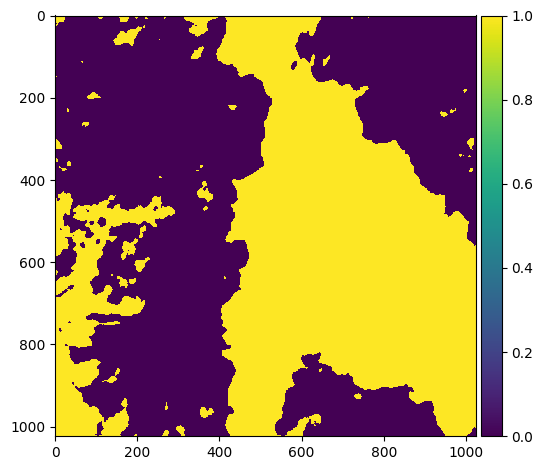

In [ ]:
imshow(preds)